# Enzyme Project
## Plots from Xixi's files

Here we try to produce nice plots from the experimental data. The idea is to take the data from the microfluidic device, fit it to a model, then estimate a confidence interval. Then we can run a significance test for the migration towards each side.

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



### Figure 2 data

In [2]:
fig2 <- read.csv("../rawdata/fig2.csv")

In [3]:
normal.vector <- colSums(fig2)/sum(fig2$Buffer)

Normalizing all data to a sum equal to sum of buffer normalized fliuorescence intensities

In [4]:
normal.vector[1] = 1

In [5]:
fig2 <- mapply("/",fig2,normal.vector)

In [6]:
fig2 <- as.data.frame(fig2)


In [7]:
# Putting data in tidy format
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)


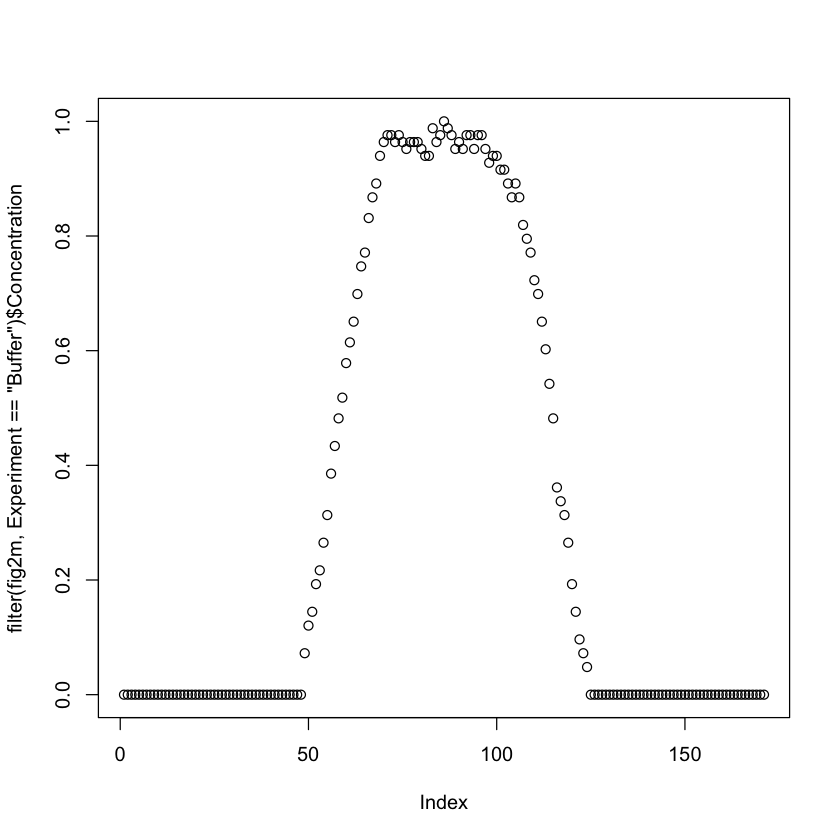

In [8]:
plot(filter(fig2m,Experiment == 'Buffer')$Concentration)

Next we specify the model. The solution for our initial conditions is $a * erf(\frac{x-c}{\sqrt{4Dt}}) +b$, where $c$ is the step point at $t=0$, and $a$ and $b$ are determined by inital concentrations. As the geometry is also subject to noise, we add two offset parameters for the inital concentration profile (the locations of the channel limits).

We then fit the model using the `nls` R package. We also use the confidence intervals given by the package to fit the upper and lower bounds of the model.

In [9]:
erf <- function(x) 2*pnorm(x*sqrt(2)) -1
# fig2mgroup <- fig2m %>% group_by(variable)
# models <- list()
m <- function(df) {
    mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = df)
    pred <- fitted(mod)
    data.frame(df,pred)
    params = confint(mod, level= 0.95)
    cc <- coef(mod)
    l <- params[,1]
    u <- params[,2]
    lwr <- l[1]*(erf((df$Distance+l[2]-100)/sqrt(4*l[3])) - erf((df$Distance+u[4]-220)/sqrt(4*l[5])))
    upr <- u[1]*(erf((df$Distance+u[2]-100)/sqrt(4*u[3])) - erf((df$Distance+l[4]-220)/sqrt(4*u[5])))
    data.frame(df,pred,lwr,upr,cc[2],cc[4])
}
result <- fig2m %>% group_by(Experiment) %>% do(m(.))
models <- fig2m %>% group_by(Experiment) %>% do(model = nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = .))
library(plyr)
result <- rename(result,c("cc.2."="offsetleft","cc.4."="offsetright"))
glimpse(result)


Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initia

Observations: 684
Variables: 8
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.345031e-17, 1.603509e-16, 4.810528e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.310999e-1...
$ upr           (dbl) 1.613805e-16, 5.379350e-16, 1.667599e-15, 5.217970e-1...
$ offsetleft    (dbl) -8.261142, -8.261142, -8.261142, -8.261142, -8.261142...
$ offsetright   (dbl) 5.438476, 5.438476, 5.438476, 5.438476, 5.438476, 5.4...


In [10]:
mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = subset(result,Experiment=='Buffer'))
confint(mod, level= 0.95)
summary(mod)

Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...


,2.5%,97.5%
alph,0.4783722,0.4845288
offset1,-8.612695,-7.909950
Dt1,76.09415,87.48447
offset2,5.092666,5.785783
Dt2,68.63914,80.25624



Formula: Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * 
    Dt1)) - erf((Distance + offset2 - 220)/sqrt(4 * Dt2)))

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
alph     0.481438   0.001547  311.25   <2e-16 ***
offset1 -8.261142   0.177426  -46.56   <2e-16 ***
Dt1     81.631500   3.106581   26.28   <2e-16 ***
offset2  5.438476   0.172612   31.51   <2e-16 ***
Dt2     74.274304   2.886510   25.73   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01684 on 166 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 5.17e-06


In [11]:
#adding channel data
result$channel <- 0
result$channel[result$Distance <= 100] <- 'left'
result$channel[result$Distance > 100 & result$Distance <= 220] <- 'center'
result$channel[result$Distance > 220] <- 'right'
glimpse(result)

Observations: 684
Variables: 9
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.345031e-17, 1.603509e-16, 4.810528e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.310999e-1...
$ upr           (dbl) 1.613805e-16, 5.379350e-16, 1.667599e-15, 5.217970e-1...
$ offsetleft    (dbl) -8.261142, -8.261142, -8.261142, -8.261142, -8.261142...
$ offsetright   (dbl) 5.438476, 5.438476, 5.438476, 5.438476, 5.438476, 5.4...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [12]:
detach("package:plyr", unload=TRUE)

Warning message:
: ‘plyr’ namespace cannot be unloaded:
  namespace ‘plyr’ is imported by ‘scales’, ‘ggplot2’, ‘reshape2’, ‘broom’ so cannot be unloaded

In [13]:
groupy <- group_by(result,channel,Experiment)
summed <- summarise(groupy, pred = sum(pred), lwr = sum(lwr), upr = sum(upr), actual = sum(Concentration))
names(summed)[2] = 'experiment'
summed <- gather(summed, "variable","value", c(pred,actual))
summed$upr[summed$variable == 'actual'] <- NaN
summed$lwr[summed$variable == 'actual'] <- NaN

Warning message:
: Removed 8 rows containing missing values (geom_errorbar).

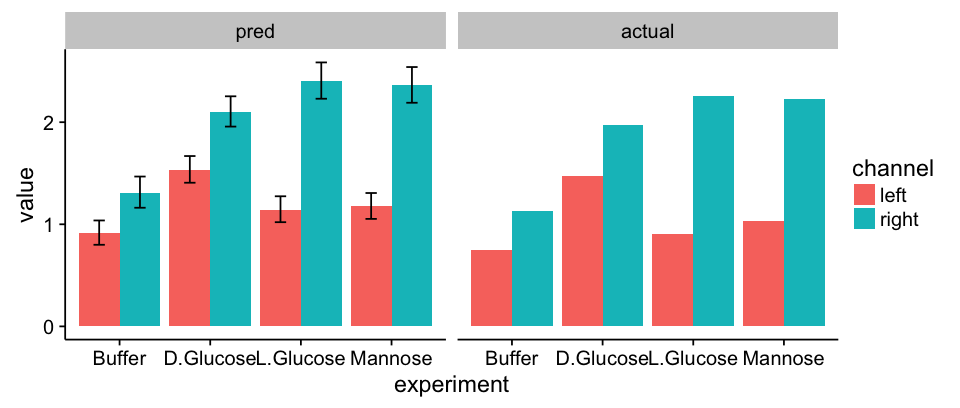

In [14]:
options(repr.plot.width = 8, repr.plot.height = 3.4)

a <- ggplot(data = subset(summed, channel != 'center'),aes(x=experiment, y=value, group = channel))
a <- a+geom_bar(stat='identity',position = "dodge", aes(fill = channel))
a <- a+geom_errorbar(aes(ymin = lwr, ymax =upr),position=position_dodge(width = 0.9),width = .25)
a + facet_grid(. ~ variable)

In [15]:
control.conc = filter(result, Experiment == 'Buffer')$Concentration
control.pred = filter(result, Experiment == 'Buffer')$pred
result %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()
result %<>% rename(Substrate = Experiment)

In [16]:
summed %<>% rename(Substrate = experiment)
control.conc <- filter(summed, Substrate == 'Buffer')$value
control.lwr <- filter(summed, Substrate == 'Buffer')$lwr
control.upr <- filter(summed, Substrate == 'Buffer')$upr
summed %<>% group_by(Substrate) %>% mutate(control.concentration = control.conc,control.lwr = control.lwr,
                                           control.upr = control.upr)
summed %<>% ungroup()


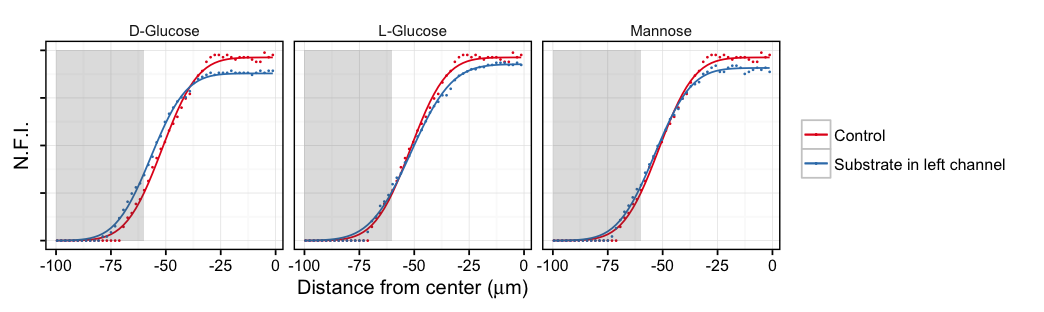

In [17]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = -100
xmax = 0

raw <- ggplot(data = filter(result,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_line(aes(y = control.pred,color = cols[2])) +
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_point(size = 0.1) +
    geom_line(aes(y = pred)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in left channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = xmin, xmax = -60, ymin = 0.000025, ymax = +1.00091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

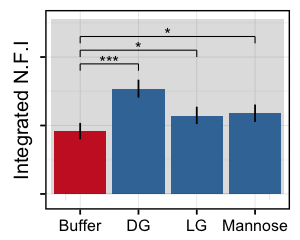

In [18]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated <- ggplot(data = filter(summed, channel == 'left', variable == 'pred') , 
                     aes(x=Substrate, y= value)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
    annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lwr,ymax = upr ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = c(1.9, 2.1, 2.3, 0.0037),
                      ann.yend = c(1.9,2.1,2.3,0.0037), 
                       ann.text = c("***","*","*",""),
                       ann.ytextoffset = c (0.04,0.04,0.04,0.04),
                       ann.xtextoffset = c (.5,0,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(0,0,0,0)

prongsize1 = 0.1
textoff = 0.3

integrated <- integrated + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated)

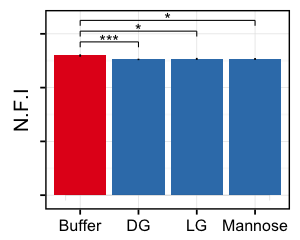

In [19]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated2 <- ggplot(data = filter(summed, channel == 'center', variable == 'pred') , 
                     aes(x=Substrate, y= value)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lwr,ymax = upr ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = c(57, 61, 65, 0.0037),
                      ann.yend = c(57,61,65,0.0037), 
                       ann.text = c("***","*","*",""),
                       ann.ytextoffset = c (0.5,0.5,0.5,0.5),
                       ann.xtextoffset = c (.5,0,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(0,0,0,0)

prongsize = 2
textoff = 1

integrated2 <- integrated2 + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated2)

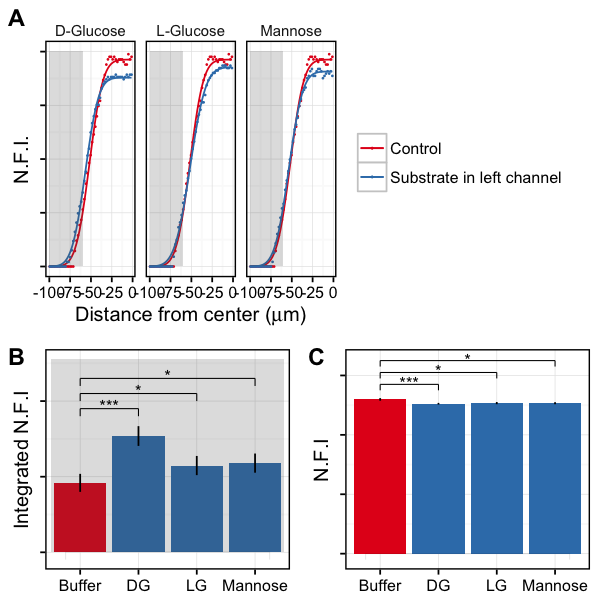

In [20]:
options(repr.plot.width = 5, repr.plot.height = 5)

line2 = plot_grid(integrated,integrated2, labels = c("B","C"),ncol = 2)

plot_grid(raw,line2, labels = c("A",""),ncol = 1,rel_heights = c(1.3,1))

### New version following A. Sen comments.

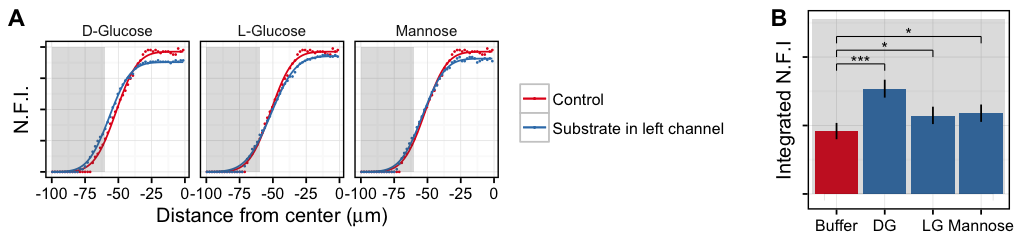

In [21]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1))

In [22]:
ggsave("./img/RoleOfCatalysisPlot.png",width = 8.5, height = 2)

ERROR: Error in grDevices::dev.off(): QuartzBitmap_Output - unable to open file './img/RoleOfCatalysisPlot.png'


In [23]:
# test between Buffer and DG
DG1 <- filter(summed, channel == 'center', variable == 'L.Glucose')$totalconc
DG1_lw <- filter(summed, channel == 'center', variable == 'L.Glucose')$lwr
DG_se <- DG1-DG1_lw
Buff1 <- filter(summed, channel == 'center', variable == 'Buffer')$totalconc
Buff1_lw <- filter(summed, channel == 'center', variable == 'Buffer')$lwr
Buff_se <- Buff1-Buff1_lw

In [24]:
ttest1 <- (-DG1 + Buff1)/sqrt(Buff_se/1.96 + DG_se/1.96)
ttest1

ERROR: Error in -DG1: invalid argument to unary operator


ERROR: Error in eval(expr, envir, enclos): object 'ttest1' not found


*Next steps*: 
- run ANOVA
- run games howell test to identify the differences
- plot the histograms with the p-values
- maybe do the qqplot of the fit?

In [25]:

anova(models$model[[1]],models$model[[2]],models$model[[3]],models$model[[4]])

,Res.Df,Res.Sum Sq,Df,Sum Sq,F value,Pr(>F)
1,166,0.04708758,NA,NA,NA,NA
2,166,0.02984191,0,0,NA,NA
3,166,0.03718797,0,0,NA,NA
4,166,0.03698036,0,0,NA,NA


In [26]:
control.conc = filter(result, Experiment == 'Buffer')$Concentration
control.pred = filter(result, Experiment == 'Buffer')$pred
result %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()
result %<>% rename(Substrate = Experiment)

ERROR: Error in eval(expr, envir, enclos): object 'Experiment' not found


ERROR: Error in eval(expr, envir, enclos): object 'Experiment' not found


ERROR: Error in eval(expr, envir, enclos): unknown column 'Experiment'


ERROR: Error: Unknown variables: Experiment.


## Plot with longer channels

In [27]:
fig2 <- read.csv("../rawdata/fig5mean.csv")

In [28]:
normal.vector <- colSums(fig2)/sum(fig2$Buffer)

In [29]:
normal.vector[1] = 1

In [30]:
fig2 <- mapply("/",fig2,normal.vector)

In [31]:
colSums(fig2)

Distance      Buffer   D.Glucose   L.Glucose     Mannose 
27770.62110    49.81197    49.81197    49.81197    49.81197

In [32]:
fig2 <- as.data.frame(fig2)


In [33]:
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)


In [34]:
#adding channel data
fig2m$channel <- 0
fig2m$channel[fig2m$Distance <= 100] <- 'left'
fig2m$channel[fig2m$Distance > 100 & fig2m$Distance <= 220] <- 'center'
fig2m$channel[fig2m$Distance > 220] <- 'right'
glimpse(fig2m)

Observations: 688
Variables: 4
$ Distance      (dbl) 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [35]:
control.conc = filter(fig2m, Experiment == 'Buffer')$Concentration
fig2m %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc)
fig2m %<>% ungroup()
fig2m %<>% rename(Substrate = Experiment)

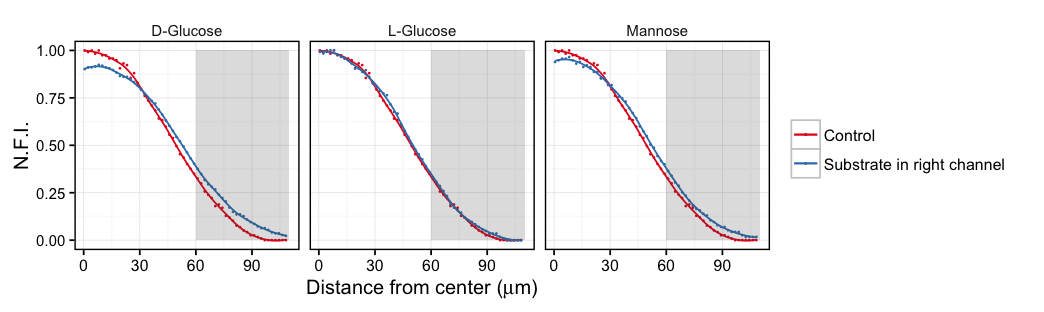

In [36]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(fig2m,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_smooth(aes(y = control.concentration,color = cols[2]),method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    geom_point(size = 0.1) +
    geom_smooth(method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in right channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=9),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

### Redo of figure 5

In [37]:
fig2 <- read.csv("../rawdata/fig5.csv")

In [38]:
head(fig2)

,Distance,Buffer,D.Glucose,L.Glucose,Mannose,Replicate
1,0,2,1,3,2,A
2,1.8884,2,1,3,2,A
3,3.7768,2,1,3,2,A
4,5.6652,2,1,3,2,A
5,7.5535,2,1,3,2,A
6,9.4419,2,1,3,2,A


In [39]:
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)

In [40]:
head(fig2m)

,Distance,Replicate,Experiment,Concentration
1,0,A,Buffer,2
2,1.8884,A,Buffer,2
3,3.7768,A,Buffer,2
4,5.6652,A,Buffer,2
5,7.5535,A,Buffer,2
6,9.4419,A,Buffer,2


In [41]:
 normalit<-function(m){
     (m - min(m))*100/sum(m-min(m))
 }

In [42]:
fig2m %<>% group_by(Replicate,Experiment) %>% mutate(Concentration = normalit(Concentration))

In [43]:
control.conc = filter(fig2m, Experiment == 'Buffer')$Concentration
fig2m %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc)
fig2m %<>% ungroup()
fig2m %<>% rename(Substrate = Experiment)

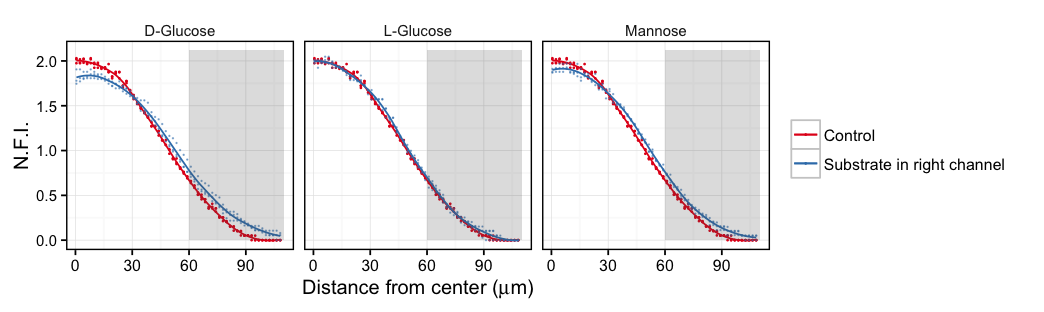

In [71]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(fig2m,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_smooth(aes(y = control.concentration,color = cols[2]),method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    geom_point(size = 0.001,alpha = 0.5) +
    geom_smooth(method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in right channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=9),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +2.120091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

In [45]:
m <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration ~ Distance, span =0.6),.))
    temp
}

In [46]:
fig2m %<>% filter(Distance >160, Distance <270)

In [47]:

bs <- fig2m %>%
    group_by(Replicate, Substrate) %>%
    do(m(.,50))

In [48]:
bs$channel <- 0
bs$channel[bs$Distance > 100 & bs$Distance <= 220] <- 'center'
bs$channel[bs$Distance > 220] <- 'right'
bs$channel <- factor(bs$channel, levels = c ('center','right'))

In [49]:
bs %<>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    mutate(concentration.channel.integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bs %<>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    mutate(.fitted.channel.integral = t(diff(Distance)) %*% .fitted[1:(length(.fitted)-1)])
bs %<>% ungroup() %>% group_by(replicate,Replicate,Substrate) %>% 
    mutate(concentration.integral = sum(concentration.channel.integral))
bs %<>% ungroup() %>% group_by(replicate,Replicate,Substrate) %>% 
    mutate(.fitted.integral = sum(.fitted.channel.integral))
# focusing_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% 
#     mutate(concentration.normalized = sum(Integral)/mean(normalized))
bs$concentration.normalized <- bs$Concentration / bs$concentration.integral
bs$.fitted.normalized <- as.vector(bs$.fitted) / as.vector(bs$.fitted.integral)
bs$.fitted.normalized.channel.integral <- as.vector(bs$.fitted.channel.integral) / as.vector(bs$.fitted.integral )
glimpse(bs)

Observations: 34,800
Variables: 17
$ replicate                           (int) 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Distance                            (dbl) 160.5129, 160.5129, 160.5129, 1...
$ Replicate                           (fctr) A, A, A, A, A, A, A, A, A, A, ...
$ Substrate                           (fctr) Buffer, Buffer, Buffer, Buffer...
$ Concentration                       (dbl) 2.018056, 2.018056, 2.018056, 2...
$ control.concentration               (dbl) 2.018056, 2.018056, 2.018056, 2...
$ .fitted                             (dbl) 2.022098, 2.022098, 2.022098, 2...
$ .se.fit                             (dbl) 0.007863075, 0.007863075, 0.007...
$ .resid                              (dbl) -0.0040417909, -0.0040417909, -...
$ channel                             (fctr) center, center, center, center...
$ concentration.channel.integral      (dbl) 91.36064, 91.36064, 91.36064, 9...
$ .fitted.channel.integral            (dbl) 91.49188, 91.49188, 91.49188, 9...
$ concentration.i

In [50]:
alpha <- 0.05
bs_recap <- bs %>%
    group_by(Substrate, Distance,channel) %>% 
    summarise(lo = quantile(.fitted.normalized,alpha/2), 
              hi = quantile(.fitted.normalized,1-alpha/2), 
              smooth = mean(.fitted.normalized), 
              orig = mean(concentration.normalized))
bs %<>% group_by(Substrate, Distance,channel) %>% 
    mutate(lo = quantile(.fitted.normalized,alpha/2), hi = quantile(.fitted.normalized,1-alpha/2))

In [51]:
head(bs_recap)

,Substrate,Distance,channel,lo,hi,smooth,orig
1,Buffer,160.5129,center,0.0005032774,0.0007471958,0.0006268455,0.0006257737
2,Buffer,162.4013,center,0.0005105682,0.0007955667,0.000638057,0.0006339751
3,Buffer,164.2897,center,0.0005308016,0.0007889179,0.0006521902,0.0006540476
4,Buffer,166.1781,center,0.0005077786,0.000783361,0.0006440221,0.0006371106
5,Buffer,168.0665,center,0.0005139949,0.0008153796,0.0006402387,0.0006464398
6,Buffer,169.9548,center,0.0005103368,0.0008100094,0.0006416782,0.0006361476


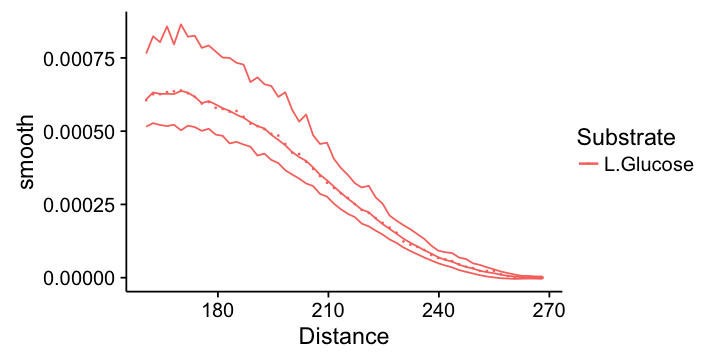

In [52]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(data=filter(bs_recap,Substrate =="L.Glucose"),aes(x=Distance,color=Substrate)) + geom_line(aes(y=smooth)) +
    geom_line(aes(y=lo)) + geom_line(aes(y=hi)) + geom_point(aes(y=orig),size=0.1)


In [53]:
bychannel_bs <- bs %>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    summarise(Integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bychannel_bs %<>% ungroup() %>% group_by(Substrate,replicate,Replicate) %>% mutate(normalized = sum(Integral))
bychannel_bs %<>% ungroup() %>% group_by(Replicate,replicate,channel,Substrate) %>% mutate(concentration = sum(Integral)/mean(normalized))
check <- bychannel_bs %>% ungroup() %>% group_by(Substrate,Replicate,replicate) %>% summarise(sum = sum(concentration))
head(check)

,Substrate,Replicate,replicate,sum
1,Buffer,A,1,1
2,Buffer,A,2,1
3,Buffer,A,3,1
4,Buffer,A,4,1
5,Buffer,A,5,1
6,Buffer,A,6,1


In [54]:
bychannel_recap <- bs_recap %>% 
    group_by(channel,Substrate) %>% 
    summarise(orig = mean(orig), smooth = mean(smooth), lo = mean(lo), hi = mean(hi))

In [55]:
head(bychannel_recap)

,channel,Substrate,orig,smooth,lo,hi
1,center,Buffer,0.0004930021,0.0004923859,0.0003923003,0.0006218491
2,center,D.Glucose,0.0004710741,0.0004709075,0.0003906399,0.000572838
3,center,L.Glucose,0.0004894831,0.0004896145,0.0004039463,0.0006441223
4,center,Mannose,0.0004792757,0.0004793398,0.000400699,0.0005910617
5,right,Buffer,6.526963e-05,6.560239e-05,5.131812e-05,8.511883e-05
6,right,D.Glucose,9.816763e-05,9.855921e-05,7.505991e-05,0.0001243375


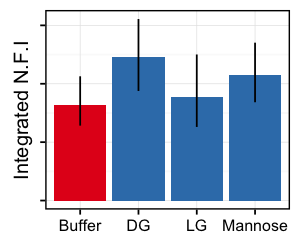

In [56]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated <- ggplot(data = filter(bychannel_recap, channel == 'right') , 
                     aes(x=Substrate, y= smooth)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

# ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
#                       ann.x = c(1, 1,1,0.75), 
#                        ann.xend = c(2,2,2,1.25), 
#                         ann.y = c(1.9, 2.1, 2.3, 0.0037),
#                       ann.yend = c(1.9,2.1,2.3,0.0037), 
#                        ann.text = c("***","*","*",""),
#                        ann.ytextoffset = c (0.04,0.04,0.04,0.04),
#                        ann.xtextoffset = c (.5,0,-0.5,0),
#                       ann.alpha = c(1,1,1,0))

# # ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# # ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
# #order is DG l,c,r LG l,c,r
# ann.data$x.offset <- c(0,1,2,3)
# ann.data$y.offset <- c(0,0,0,0)

# prongsize1 = 0.1
# textoff = 0.3

# integrated <- integrated + 
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
#     geom_text(data = ann.data, size= 3.5,
#               aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
#     scale_alpha(guide = 'none')

                
print(integrated)

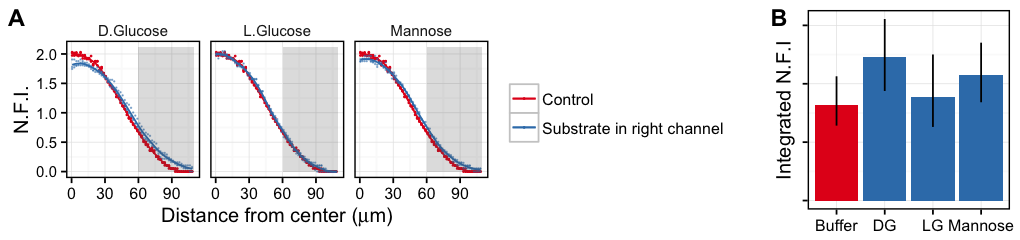

In [57]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1))

### New Figure 5, rev 2 (simplify)

In [3]:
fig5 <- read.csv("../data/fig5.csv")

In [4]:
fig5 <- gather(fig5,"Experiment","Concentration",Buffer:Mannose)

In [5]:
 normalit<-function(m){
   (m - min(m))*100/sum(m-min(m))
 }

In [6]:
fig5 %<>% group_by(Replicate,Experiment) %>% mutate(Concentration = normalit(Concentration))

In [7]:
head(fig5)

Distance,Replicate,Experiment,Concentration
0.0000,A,Buffer,0
1.8884,A,Buffer,0
3.7768,A,Buffer,0
5.6652,A,Buffer,0
7.5535,A,Buffer,0
9.4419,A,Buffer,0


In [8]:
fig5$channel <- 0
fig5$channel[fig5$Distance <= 100] <- 'left'
fig5$channel[fig5$Distance > 100 & fig5$Distance <= 220] <- 'center'
fig5$channel[fig5$Distance > 220] <- 'right'
fig5$channel <- factor(fig5$channel, levels = c ('left','center','right'))

In [9]:
fig5_recap <- fig5 %>% group_by(Experiment,channel) %>% summarise(TotalConc= sum(Concentration),
                                                                  ConcSem = qt(0.975,df=2)*sd(Concentration)/sqrt(3))

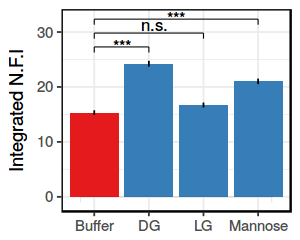

In [11]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
cols <- hue_pal()(2)
integrated <- ggplot(data = filter(fig5_recap, channel == 'right') , 
                     aes(x=Experiment, y= TotalConc)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=9),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = TotalConc-ConcSem,ymax =  TotalConc+ConcSem ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Control","D-Glucose","L-Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = .15*c(1.9, 2.1, 2.3, 0.0037),
                      ann.yend = .15*c(1.9,2.1,2.3,0.0037), 
                       ann.text = c("***","n.s.","***",""),
                       ann.ytextoffset = .15*c (1,10,1,0.04),
                       ann.xtextoffset = c (.5,0.1,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(27,29.5,32,0)

prongsize1 = 1.02
textoff = 100

integrated <- integrated + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated)

In [12]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1.16))

ERROR: Error in ggplot_to_gtable(x): Argument needs to be of class "ggplot" or "gtable"


In [78]:
ggsave("../img/RoleOfCatalysisPlotv4.png",width = 8.5, height = 2)

In [13]:
fig5_recap

Experiment,channel,TotalConc,ConcSem
Buffer,left,10.546554,0.2698320
Buffer,center,274.121536,1.1982379
Buffer,right,15.331911,0.4293326
D.Glucose,left,12.826901,0.2992800
D.Glucose,center,262.938421,1.0208770
D.Glucose,right,24.234678,0.5299147
L.Glucose,left,9.498536,0.2624715
L.Glucose,center,273.784644,1.1751333
L.Glucose,right,16.716820,0.4451796
Mannose,left,12.000776,0.2836930


In [15]:
fig5_recap %>% group_by(Experiment) %>% summarise(c = sum(TotalConc))

Experiment,c
Buffer,300
D.Glucose,300
L.Glucose,300
Mannose,300


In [27]:
fig5_recap %>% select(Experiment, channel, TotalConc) %>%
spread(channel, TotalConc) %>% 
mutate(percentage_right = right/300)

Experiment,left,center,right,percentage_right
Buffer,10.546554,274.1215,15.33191,0.05110637
D.Glucose,12.826901,262.9384,24.23468,0.08078226
L.Glucose,9.498536,273.7846,16.71682,0.05572273
Mannose,12.000776,266.9706,21.02861,0.07009538


In [28]:
fig5_recap %>% select(Experiment, channel, ConcSem) %>%
spread(channel, ConcSem) %>% 
mutate(percentage_right = right/300)

Experiment,left,center,right,percentage_right
Buffer,0.2698320,1.198238,0.4293326,0.001431109
D.Glucose,0.2992800,1.020877,0.5299147,0.001766382
L.Glucose,0.2624715,1.175133,0.4451796,0.001483932
Mannose,0.2836930,1.107229,0.4944543,0.001648181


In [22]:
24.23468/300

[1] 0.0811

In [24]:
(24.34-15.33)/15.33

[1] 0.5877365